# 📑 [Fuel Consumption EDA & Prediction](https://www.kaggle.com/code/sercanyesiloz/fuel-consumption-eda-prediction)
##  kaggul kaggul Study week 2 - Auto-mpg dataset

In [192]:
# !pip install nb_black

<IPython.core.display.Javascript object>

In [193]:
# !pip install catboost

<IPython.core.display.Javascript object>

In [194]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_log_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

<IPython.core.display.Javascript object>

```
import os: 운영체제(OS : Operating System) 제어
import warnings: 경고 제어
from scipy: 과학기술계산을 위한 Python 라이브러리. NumPy, Matplotlib, pandas, SymPy와 연계되어 있다
from scipy.stats: stats 서브패키지는 확률분포 분석을 위한 다양한 기능을 제공
norm(가우시안 정규분포), skew(왜도)
sklearn.base.clone: Construct a new unfitted estimator with the same parameters.
sklearn.pipeline: 생산라인에서 동시에 여러 공정 프로세스를 효율적이게 하는 것처럼, 머신러닝에서 모델을 가속, 재사용, 관리 및 배포하는 프로세스를 구현하고 표준화하는 것을 의미 -> 파이프라인을 사용하면 데이터 전처리와 모델 학습, 예측까지 한번에 가능하여 코드가 간결해짐(출처)
```

In [195]:
# Visualization
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

<IPython.core.display.Javascript object>

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


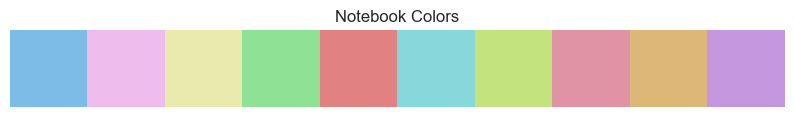

<IPython.core.display.Javascript object>

In [196]:
# ML Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

%matplotlib inline
%load_ext nb_black
warnings.filterwarnings("ignore")
colors = [
    "#7DBCE6",
    "#EEBDEE",
    "#EAEAAF",
    "#8FE195",
    "#E28181",
    "#87D8DB",
    "#C2E37D",
    "#DF93A4",
    "#DCB778",
    "#C497DE",
]
sns.palplot(sns.color_palette(colors))
plt.title("Notebook Colors", size=12)
plt.axis("off")
plt.show()

In [198]:
auto = pd.read_csv("data/auto-mpg.csv", na_values="?")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


<IPython.core.display.Javascript object>

- na_values : Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values.
    - NaN 으로 인식해야 하는 문자열을 설정할수 있다. scalar, str, list-like, or dict 가능.

In [199]:
def auto_preprocess(dataframe):
    df_ = dataframe.copy()
    auto_misspelled = {
        "chevroelt": "chevrolet",
        "chevy": "chevtlet",
        "vokswagen": "volkswagen",
        "vw": "volkswagen",
        "hi": "harvester",
        "maxda": "mazda",
        "toyouta": "toyota",
        "mercedes-benz": "mercedes",
    }

    # car name 컬럼에서 첫번째 단어를 추출해서 제조사 파생변수를 만든다.
    df_["make"] = [
        auto_misspelled[key].title() if key in auto_misspelled else key.title()
        for key in [i.split()[0] for i in df_["car name"]]
    ]
    #     for key in [i.split()[0] for i in df_["car name"]]:
    #         if key in auto_misspelled:
    #             auto_misspelled[key].title()
    #         else:
    #             key.title()

    # car name 컬럼에서 첫번째 이후의 단어들을 추출해서 하나로 묶어서 자동차 이름 파생변수로 만들어 준다.
    df_["name"] = [" ".join(i.split()[1:]).title() for i in df_["car name"]]
    #     for i in df_["car name"]:
    #         print(" ".join(i.split()[1:]).title())

    df_ = df_.drop(columns=["car name"], axis=1)
    return df_


df = auto_preprocess(auto)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,make,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,Ford,Torino


<IPython.core.display.Javascript object>

- The title() method returns a string where the first character in every word is upper case.
    - title() 메서드는 모든 단어의 맨 첫 글자를 대문자로 바꿔준다.


In [200]:
def check_class(dataframe):
    nunique_df = pd.DataFrame(
        {
            "Variavle": dataframe.columns,
            "Classes": [dataframe[i].nunique() for i in dataframe.columns],
        }
    )

    nunique_df = nunique_df.sort_values("Classes", ascending=False)
    nunique_df = nunique_df.reset_index(drop=True)
    return nunique_df


check_class(df)

,Variavle,Classes
0,weight,351
1,name,300
2,mpg,129
3,acceleration,95
4,horsepower,93
5,displacement,82
6,make,31
7,model year,13
8,cylinders,5
9,origin,3


<IPython.core.display.Javascript object>

In [201]:
df.nunique().sort_values(ascending=False)

weight          351
name            300
mpg             129
acceleration     95
horsepower       93
displacement     82
make             31
model year       13
cylinders         5
origin            3
dtype: int64

<IPython.core.display.Javascript object>

### 수치형, 명목형, 자동차 데이터 분리

In [202]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # 명목형 데이터
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]

    # 숫자형이지만 범주형인 데이터
    num_but_cat = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() < cat_th and dataframe[col].dtype != "O"
    ]

    # 범주형이면서 자동차를 나타내는 데이터
    cat_but_car = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"
    ]

    # 자동차인 데이터를 제외한 범주형 테이더
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # 수치형데이터
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    # 수치형이지만 범주형 데이터를 제외한 진짜 수치형 데이터!
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 10
cat_cols: 2
num_cols: 6
cat_but_car: 2
num_but_cat: 2


<IPython.core.display.Javascript object>

### 기술통계를 히트맵으로 보기

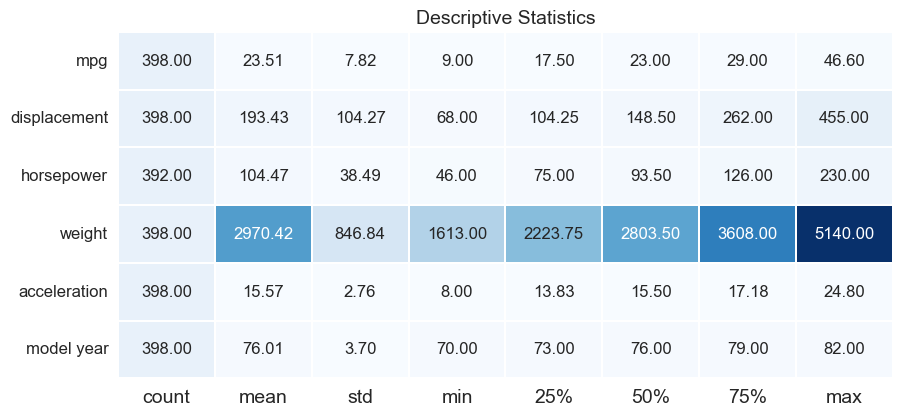

<IPython.core.display.Javascript object>

In [203]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f, ax = plt.subplots(figsize=(10, desc.shape[0] * 0.75))

    sns.heatmap(
        desc,
        annot=True,
        cmap="Blues",
        fmt=".2f",
        ax=ax,
        linecolor="white",
        linewidths=1.3,
        cbar=False,
        annot_kws={"size": 12},
    )
    plt.xticks(size=14)
    plt.yticks(size=12, rotation=0)
    plt.title("Descriptive Statistics", size=14)
    plt.show()


desc_stats(df[num_cols])

## EDA

### Analysis of Categorical Variables

In [204]:
def cat_summary(dataframe, col_name):
    get_labels = lambda x: x.value_counts().keys()
    get_values = lambda x: x.value_counts().values

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=("Countplot", "Percentages"),
        specs=[[{"type": "xy"}, {"type": "domain"}]],
    )

    fig.add_trace(
        go.Bar(
            y=get_values(dataframe[col_name]).tolist(),
            x=[str(i) for i in dataframe[col_name].value_counts().index],
            text=get_values(dataframe[col_name]).tolist(),
            textfont=dict(size=14),
            name=col_name,
            textposition="auto",
            marker=dict(color=colors),
            showlegend=False,
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Pie(
            labels=get_labels(dataframe[col_name]),
            values=get_values(dataframe[col_name]),
            textfont=dict(size=14),
            textposition="auto",
            showlegend=False,
            name=col_name,
            marker=dict(colors=colors),
        ),
        row=1,
        col=2,
    )
    fig.update_layout(
        title={
            "text": col_name,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        template="ggplot2",
    )

    iplot(fig)


for col in cat_cols:
    cat_summary(df, col)

<IPython.core.display.Javascript object>

### Analysis of Numerical Variables 
- 박스, 히스토그램 시각화

In [205]:
def num_summary(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Quantiles", "Distribution"))

    fig.add_trace(
        go.Box(
            y=dataframe[col_name],
            name=str(col_name),
            showlegend=False,
            marker_color=colors[1],
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Histogram(
            x=dataframe[col_name],
            xbins=dict(start=dataframe[col_name].min(), end=dataframe[col_name].max()),
            showlegend=False,
            name=str(col_name),
            marker=dict(color=colors[0], line=dict(color="#DBE6EC", width=1)),
        ),
        row=1,
        col=2,
    )

    fig.update_layout(
        title={
            "text": col_name,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        template="ggplot2",
    )

    iplot(fig)


for i in num_cols:
    num_summary(df, i)

<IPython.core.display.Javascript object>

In [206]:
df[["horsepower", "make", "name"]].sort_values("horsepower", ascending=False)[:10]

,horsepower,make,name
116,230.0,Pontiac,Grand Prix
95,225.0,Buick,Electra 225 Custom
13,225.0,Buick,Estate Wagon (Sw)
8,225.0,Pontiac,Catalina
6,220.0,Chevrolet,Impala
94,215.0,Chrysler,New Yorker Brougham
7,215.0,Plymouth,Fury Iii
25,215.0,Ford,F250
27,210.0,Dodge,D200
67,208.0,Mercury,Marquis


<IPython.core.display.Javascript object>

### TOP 10 Horsepower

In [207]:
fig = px.bar(
    df[["horsepower", "make", "name"]].sort_values("horsepower", ascending=False)[:10],
    y="name",
    x="horsepower",
    text="horsepower",
    labels={"name": "", "horsepower": "Horsepower", "make": ""},
    color="make",
    color_discrete_sequence=colors,
)

fig.update_layout(
    title=dict(
        text="TOP 10 Horsepower", x=0.5, y=0.95, xanchor="center", yanchor="top"
    ),
    xaxis=dict(title="Horsepower"),
    yaxis=dict(categoryorder="total ascending"),
    font=dict(family="Verdana", size=14, color="gray"),
    template="ggplot2",
)


fig.show()

<IPython.core.display.Javascript object>

### TOP 10 Weight

In [208]:
fig = px.bar(
    df[["weight", "make", "name"]].sort_values("weight", ascending=False)[:10],
    y="name",
    x="weight",
    text="weight",
    labels={"name": "", "weight": "Weight", "make": ""},
    color="make",
    color_discrete_sequence=colors,
)

fig.update_layout(
    title=dict(text="TOP 10 Weight", x=0.5, y=0.95, xanchor="center", yanchor="top"),
    xaxis=dict(title="Weight"),
    yaxis=dict(categoryorder="total ascending"),
    font=dict(family="Verdana", size=14, color="gray"),
    template="ggplot2",
)

fig.show()

<IPython.core.display.Javascript object>

### Horsepower - MPG - Weight

In [209]:
data = [
    go.Scatter(
        x=df["mpg"],
        y=df["horsepower"],
        mode="markers",
        text=df["weight"],
        marker=dict(
            size=10,
            color=df["weight"],
            showscale=True,
            colorscale="Viridis",
            colorbar=dict(title="Weight"),
            opacity=0.8,
        ),
    )
]

layout = go.Layout(
    title=dict(
        text="Horsepower - MPG - Weight", y=0.9, x=0.5, xanchor="center", yanchor="top"
    ),
    xaxis=dict(title="MPG"),
    yaxis=dict(title="Horsepower"),
    template="ggplot2",
)


fig = go.Figure(data=data, layout=layout)
iplot(fig)

<IPython.core.display.Javascript object>

In [210]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,make,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,Ford,Torino


<IPython.core.display.Javascript object>

In [211]:
data = go.Scatter3d(
    x=df["horsepower"],
    y=df["mpg"],
    z=df["displacement"],
    mode="markers",
    marker=dict(
        color=df["weight"],
        showscale=True,
        colorbar=dict(title="Weight"),
        colorscale="Viridis",
        opacity=0.7,
    ),
)

layout = go.Layout(
    title=dict(
        text="Horsepower - MPG - Displacement - Weght",
        y=0.9,
        x=0.5,
        xanchor="center",
        yanchor="top",
    ),
    scene=dict(
        xaxis=dict(title="Horsepower"),
        yaxis=dict(title="MPG"),
        zaxis=dict(title="Displacement"),
    ),
    template="ggplot2",
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

<IPython.core.display.Javascript object>

### Pairwise Relationships

In [212]:
fig = go.Figure(
    data=go.Splom(
        dimensions=[
            dict(label="mpg", values=df["mpg"]),
            dict(label="displacement", values=df["displacement"]),
            dict(label="horsepower", values=df["horsepower"]),
            dict(label="weight", values=df["weight"]),
            dict(label="acceleration", values=df["acceleration"]),
            dict(label="model year", values=df["model year"]),
        ],
        showupperhalf=True,
        text=df["cylinders"],
        marker=dict(
            color=[colors[i] for i in df["cylinders"].astype("category").cat.codes],
            showscale=False,
            opacity=0.65,
        ),
    )
)

fig.update_layout(
    title={
        "text": "Pairwise Relationships by Cylinders",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
        "y": 0.95,
    },
    width=950,
    height=950,
    template="ggplot2",
)

iplot(fig)

<IPython.core.display.Javascript object>

In [213]:
fig = go.Figure(
    data=go.Splom(
        dimensions=[
            dict(label="mpg", values=df["mpg"]),
            dict(label="displacement", values=df["displacement"]),
            dict(label="horsepower", values=df["horsepower"]),
            dict(label="weight", values=df["weight"]),
            dict(label="acceleration", values=df["acceleration"]),
            dict(label="model year", values=df["model year"]),
        ],
        showupperhalf=True,
        text=df["origin"],
        marker=dict(
            color=[colors[i] for i in df["origin"].astype("category").cat.codes],
            showscale=False,
            opacity=0.65,
        ),
    )
)

fig.update_layout(
    title={
        "text": "Pairwise Relationships by Origins",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
        "y": 0.95,
    },
    width=950,
    height=950,
    template="ggplot2",
)

iplot(fig)

<IPython.core.display.Javascript object>

### Correlation Coefficients

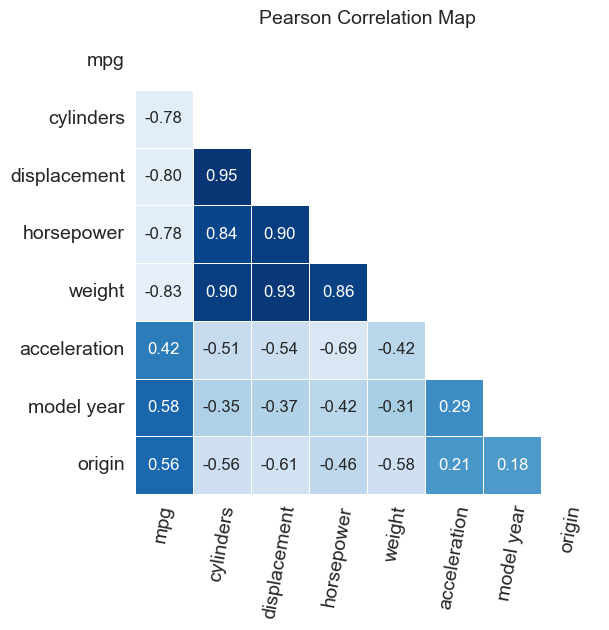

<IPython.core.display.Javascript object>

In [214]:
def corr_map(dataframe, method="pearson", title=None):
    # 예외처리구문
    # pearson, spearman 이 아닐 경우 에러메세지
    assert method in ["pearson", "spearman"], "Invalid Correlation Method"

    sns.set_style("white")
    matrix = np.triu(dataframe.corr(method=method))
    f, ax = plt.subplots(figsize=(matrix.shape[0] * 0.75, matrix.shape[1] * 0.75))

    sns.heatmap(
        dataframe.corr(method=method),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax,
        vmin=-1,
        vmax=1,
        mask=matrix,
        cmap="Blues",
        linewidths=0.4,
        linecolor="white",
        annot_kws={"size": 12},
    )

    plt.xticks(rotation=80, size=14)
    plt.yticks(rotation=0, size=14)
    if title == None:
        title = f"{method.title()} Correlation Map"
    plt.title(title, size=14)
    plt.show()


# corr_map(df, "spearman")
corr_map(df)

## Missing Values

In [215]:
def check_missing(dataframe):
    missing = pd.DataFrame(
        {
            "Variable": dataframe.columns,
            "Missing": [dataframe[i].isnull().sum() for i in dataframe.columns],
            "Ratio": [
                100 * dataframe[i].isnull().sum() / dataframe.shape[0]
                for i in dataframe.columns
            ],
        }
    )
    missing = missing[missing["Missing"] > 0]

    if missing.shape[0] == 0:
        print("No missing values")
    else:
        missing = missing.reset_index(drop=True)
        missing = missing.sort_values("Missing", ascending=False)

    return missing


check_missing(df)

,Variable,Missing,Ratio
0,horsepower,6,1.507538


<IPython.core.display.Javascript object>

In [216]:
# 수업 시간에 배웠던 결측치 처리방법 적용
(df.isnull().sum() / df.shape[0]) * 100
missing_df = pd.concat(
    [df.isnull().sum(), (df.isnull().sum() / df.shape[0]) * 100], axis=1
)
missing_df = missing_df.rename(columns={0: "Missing", 1: "Ratio"})
missing_df[missing_df["Missing"] > 0]

,Missing,Ratio
horsepower,6,1.507538


<IPython.core.display.Javascript object>

In [217]:
df.groupby(cat_cols).agg({"horsepower": ["mean", "median"]})

horsepower       
                        mean median
cylinders origin                   
3         3        99.250000   98.5
4         1        80.956522   84.0
          2        78.311475   76.0
          3        75.579710   70.0
5         2        82.333333   77.0
6         1        99.671233  100.0
          2       113.500000  122.5
          3       115.833333  118.0
8         1       158.300971  150.0

<IPython.core.display.Javascript object>

In [218]:
df.groupby(cat_cols)["horsepower"].median()

cylinders  origin
3          3          98.5
4          1          84.0
           2          76.0
           3          70.0
5          2          77.0
6          1         100.0
           2         122.5
           3         118.0
8          1         150.0
Name: horsepower, dtype: float64

<IPython.core.display.Javascript object>

In [219]:
df.groupby(cat_cols)[["horsepower"]].transform("median")

,horsepower
0,150.0
1,150.0
2,150.0
3,150.0
4,150.0
...,...
393,84.0
394,76.0
395,84.0
396,84.0


<IPython.core.display.Javascript object>

- groupby().col.transform() : Groupby 후 통계량을 집계하여 새 칼럼 추가하기

In [220]:
df["horsepower"] = df["horsepower"].fillna(
    df.groupby(cat_cols)["horsepower"].transform("median")
)

check_missing(df)

No missing values


,Variable,Missing,Ratio


<IPython.core.display.Javascript object>

## Outliers

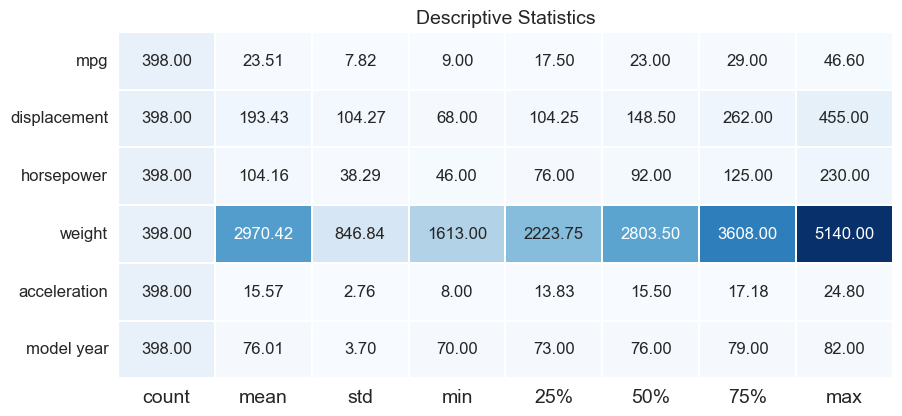

<IPython.core.display.Javascript object>

In [221]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=q1, q3=q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in df[num_cols].columns:
    replace_with_thresholds(df, col, q1=0.1, q3=0.9)

desc_stats(df[num_cols])

## Feature Engineering
### MPG (Dependent Variable)

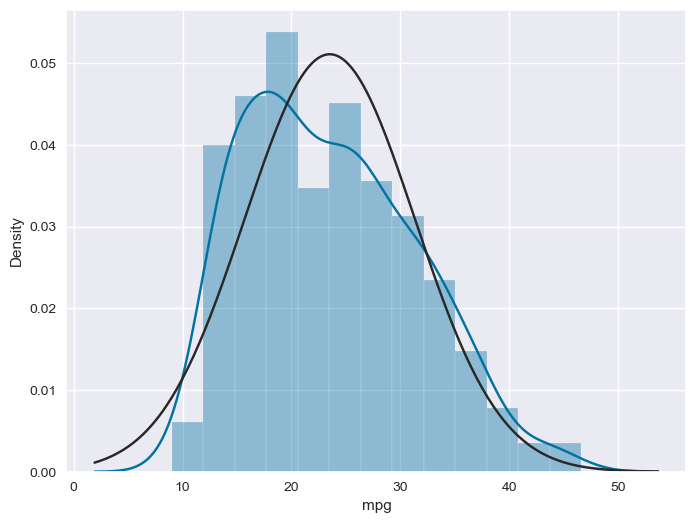

mu: 23.514572864321607 sigma = 7.806159061274433


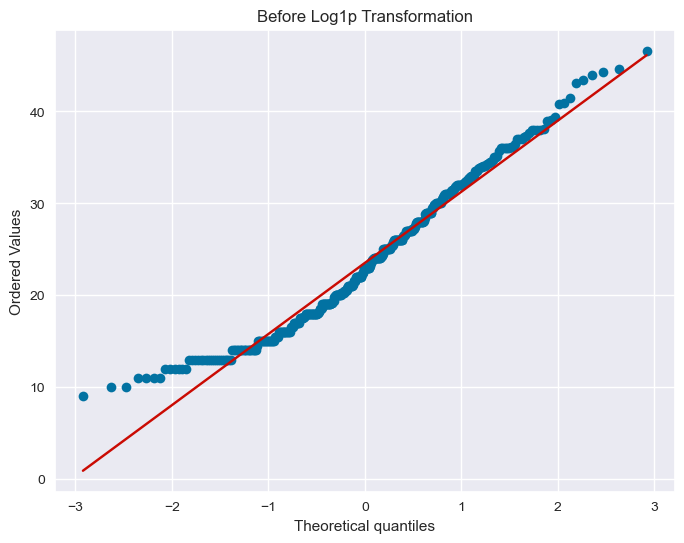

<IPython.core.display.Javascript object>

In [222]:
# 로그 변환 전
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
sns.distplot(df.mpg, fit=norm)
plt.show()

(mu, sigma) = norm.fit(df["mpg"])

print("mu: {} sigma = {}".format(mu, sigma))

fig = plt.figure(figsize=(8, 6))
stats.probplot(df["mpg"], plot=plt)
plt.title("Before Log1p Transformation", size=12)
plt.show()

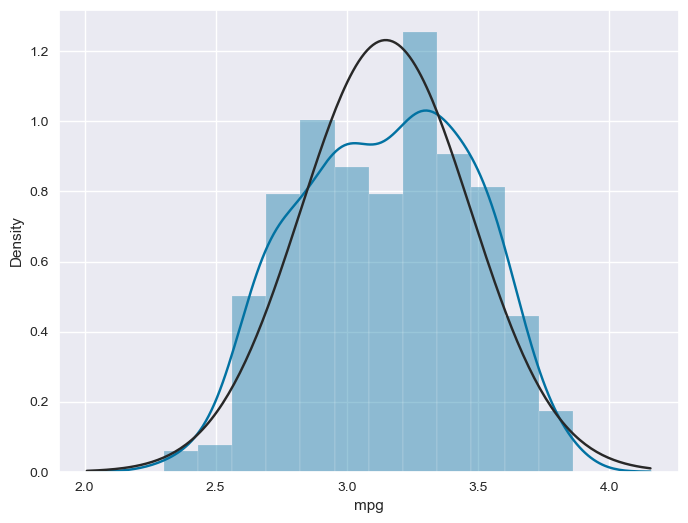

mu: 3.1478302770344047 sigma = 0.32375928015327066


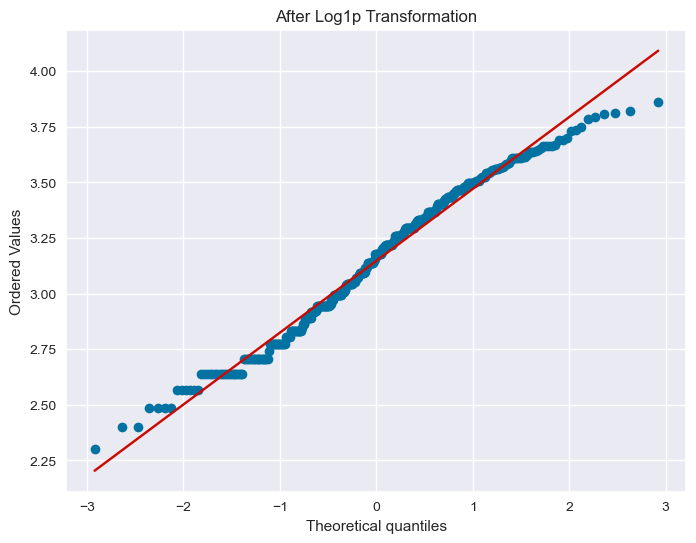

<IPython.core.display.Javascript object>

In [223]:
# 로그 변환 후
df["mpg"] = np.log1p(df["mpg"])
plt.figure(figsize=(8, 6))
sns.distplot(df.mpg, fit=norm)
plt.show()

(mu, sigma) = norm.fit(df["mpg"])

print("mu: {} sigma = {}".format(mu, sigma))

fig = plt.figure(figsize=(8, 6))
stats.probplot(df["mpg"], plot=plt)
plt.title("After Log1p Transformation", size=12)
plt.show()

## Encoding

In [224]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(
        dataframe, columns=categorical_cols, drop_first=drop_first
    )
    return dataframe


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [
    col
    for col in df.columns
    if df[col].dtype not in [int, float] and df[col].nunique() == 2
]
print("Binary Variables: {}".format(binary_cols))

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols.append("make")
print("Multiclass Variables: {}".format(ohe_cols))

Binary Variables: []
Multiclass Variables: ['cylinders', 'origin', 'make']


<IPython.core.display.Javascript object>

In [225]:
df["cylinders"] = df["cylinders"].astype(int)
df["origin"] = df["origin"].astype(int)
df = one_hot_encoder(df, ohe_cols)
df.head()

,mpg,displacement,horsepower,weight,acceleration,model year,name,cylinders_3,cylinders_4,cylinders_5,...,make_Peugeot,make_Plymouth,make_Pontiac,make_Renault,make_Saab,make_Subaru,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo
0,2.944439,307.0,130.0,3504.0,12.0,70,Chevelle Malibu,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,Skylark 320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,Satellite,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,Rebel Sst,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,Torino,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [226]:
check_class(df)

,Variavle,Classes
0,weight,351
1,name,300
2,mpg,129
3,acceleration,95
4,horsepower,93
5,displacement,82
6,model year,13
7,make_Opel,2
8,make_Harvester,2
9,make_Honda,2


<IPython.core.display.Javascript object>

In [227]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 46
cat_cols: 39
num_cols: 6
cat_but_car: 1
num_but_cat: 39


<IPython.core.display.Javascript object>

In [228]:
useless_cols = [
    col
    for col in df.columns
    if df[col].nunique() == 2
    and (df[col].value_counts() / len(df) < 0.03).any(axis=None)
]

print("Number of useless variables: {}".format(len(useless_cols)))
df.drop(useless_cols, axis=1, inplace=True)

Number of useless variables: 21


<IPython.core.display.Javascript object>

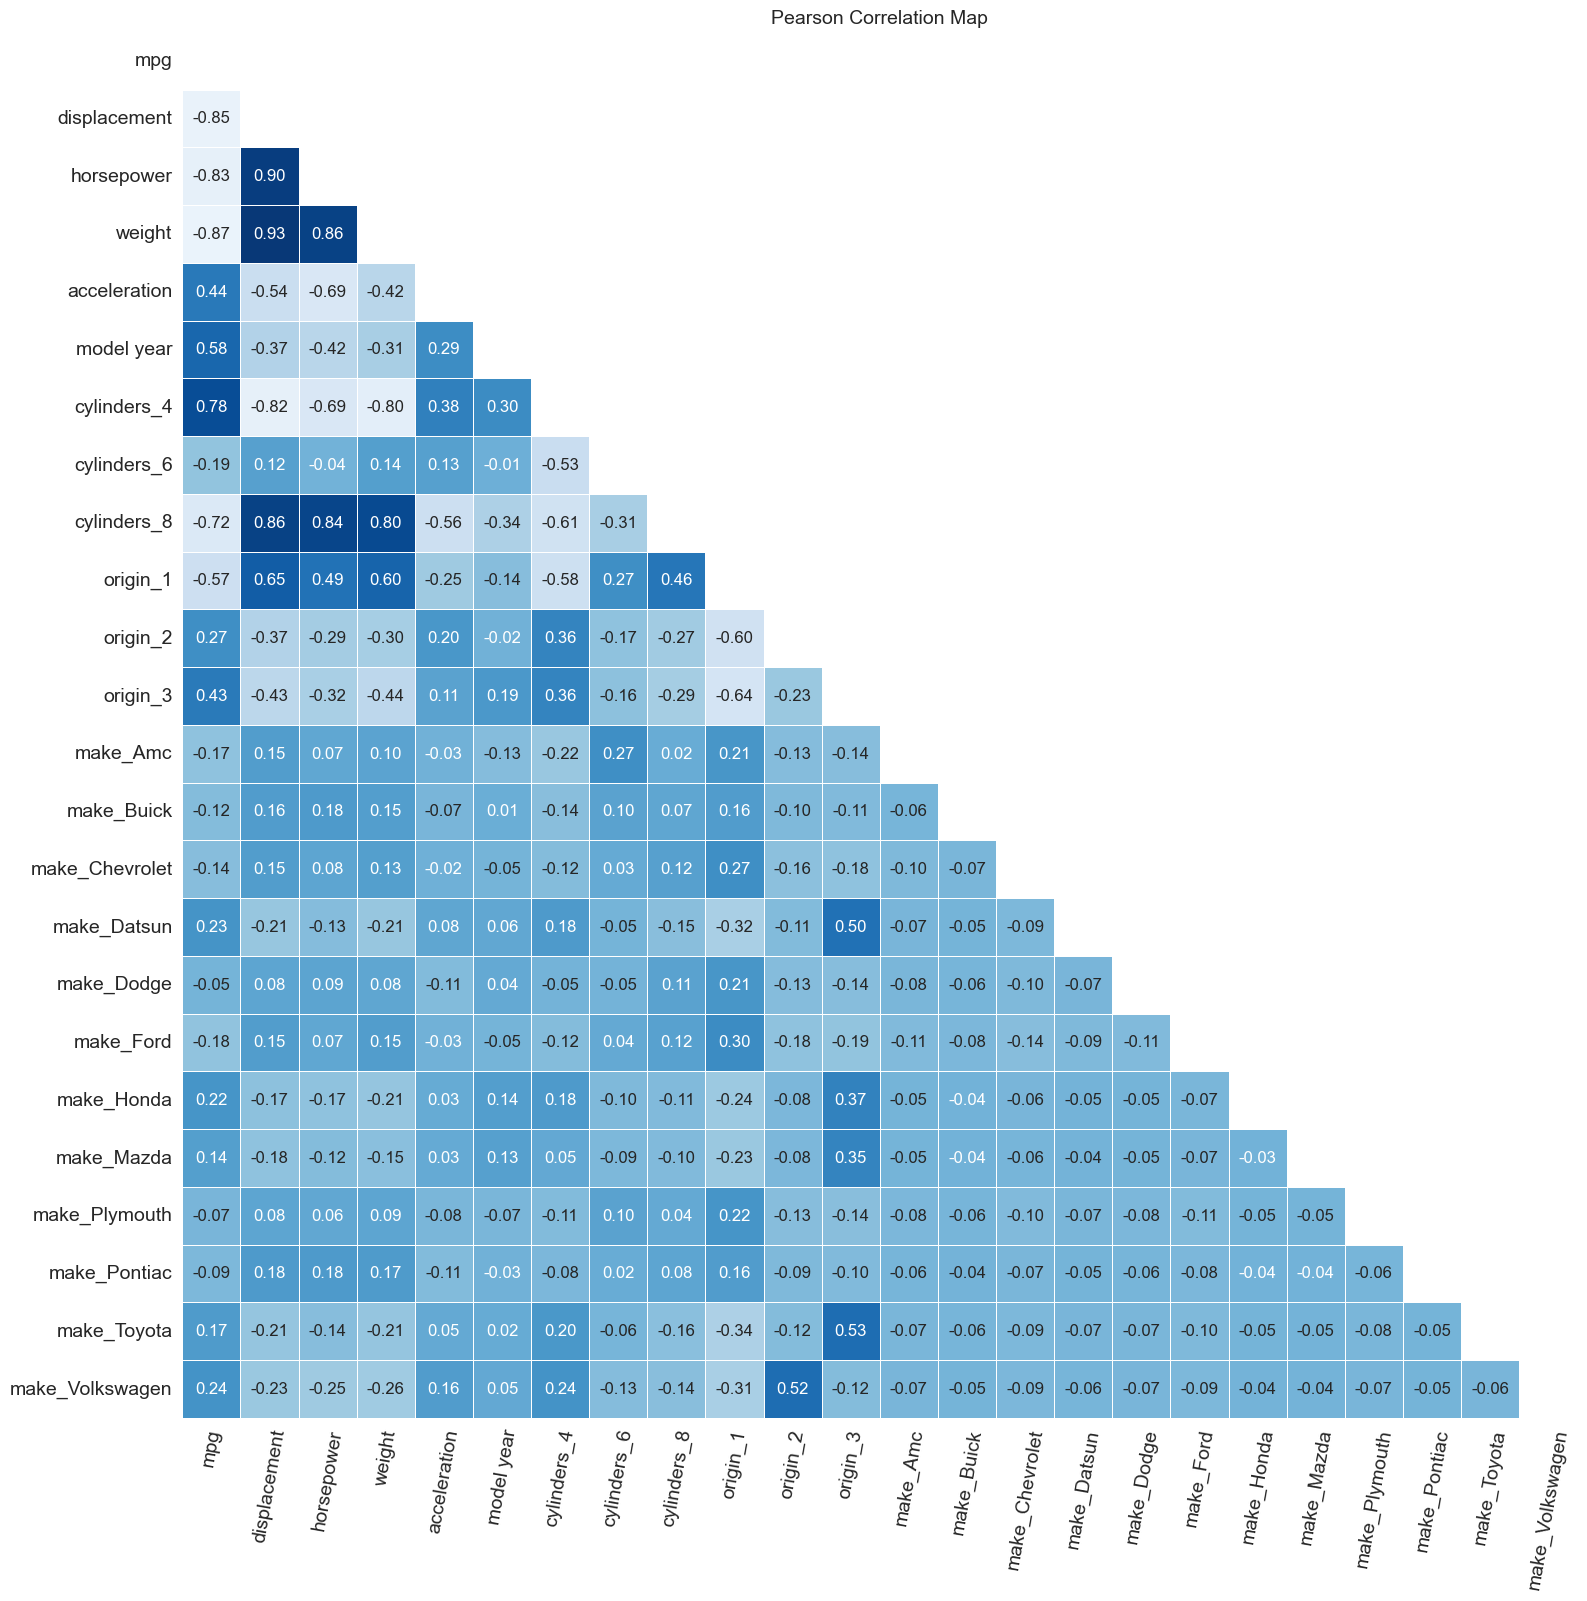

<IPython.core.display.Javascript object>

In [231]:
corr_map(df)

## Preprocessing

In [239]:
X = df.drop(columns=["mpg", "name"], axis=1)
y = df["mpg"]

test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

<IPython.core.display.Javascript object>

## Modeling

### 수동 모델링

In [240]:
def train_pipeline(pipe):

    scaler = pipe.steps[0][1].__class__.__name__
    regressor = pipe.steps[1][1].__class__.__name__
    if scaler == "NoneType":
        scaler = "Without Scaling"

    # Fitting Model
    pipe.fit(X_train, y_train)

    # Get Predictions
    y_pred = pipe.predict(X_test)
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    # Model Evaluation
    r2 = r2_score(y_test_exp, y_pred_exp)
    mse = mean_squared_error(y_test_exp, y_pred_exp)
    rmse = mean_squared_error(y_test_exp, y_pred_exp, squared=False)
    msle = mean_squared_log_error(y_test_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    return scaler, regressor, r2, mse, rmse, msle, mape, mae


regressors = [
    KNeighborsRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    XGBRegressor(),
    LGBMRegressor(),
    AdaBoostRegressor(),
    SVR(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
]

scalers = [None, StandardScaler(), RobustScaler()]
eval_data = pd.DataFrame(
    {
        "model": [],
        "scaler": [],
        "r2": [],
        "mse": [],
        "rmse": [],
        "msle": [],
        "mape": [],
        "mae": [],
    }
)
for reg in regressors:
    for sc in scalers:
        pipeline = Pipeline([("scaler", sc), ("reg", reg)])
        scaler, regressor, r2, mse, rmse, msle, mape, mae = train_pipeline(pipeline)
        eval_data = eval_data.append(
            pd.DataFrame(
                {
                    "model": [regressor],
                    "scaler": [scaler],
                    "r2": [r2],
                    "mse": [mse],
                    "rmse": [rmse],
                    "msle": [msle],
                    "mape": [mape],
                    "mae": [mae],
                }
            )
        )
    eval_data = eval_data.reset_index(drop=True)
eval_data.sort_values("rmse")

,model,scaler,r2,mse,rmse,msle,mape,mae
28,RandomForestRegressor,StandardScaler,0.914084,4.619416,2.149283,0.007938,0.072158,1.609703
29,RandomForestRegressor,RobustScaler,0.909561,4.862593,2.205129,0.008085,0.070399,1.579041
26,SVR,RobustScaler,0.909472,4.867378,2.206213,0.008891,0.077155,1.688799
18,LGBMRegressor,Without Scaling,0.909443,4.868922,2.206563,0.008655,0.078377,1.730582
9,Ridge,Without Scaling,0.909414,4.870499,2.206921,0.009843,0.077325,1.634438
25,SVR,StandardScaler,0.908107,4.940783,2.222787,0.009207,0.080166,1.750804
20,LGBMRegressor,RobustScaler,0.907927,4.950431,2.224956,0.008971,0.079382,1.750230
11,Ridge,RobustScaler,0.907521,4.972254,2.229855,0.009996,0.077570,1.645919
5,LinearRegression,RobustScaler,0.907006,4.999959,2.236059,0.010016,0.078173,1.653493
4,LinearRegression,StandardScaler,0.907006,4.999959,2.236059,0.010016,0.078173,1.653493


<IPython.core.display.Javascript object>

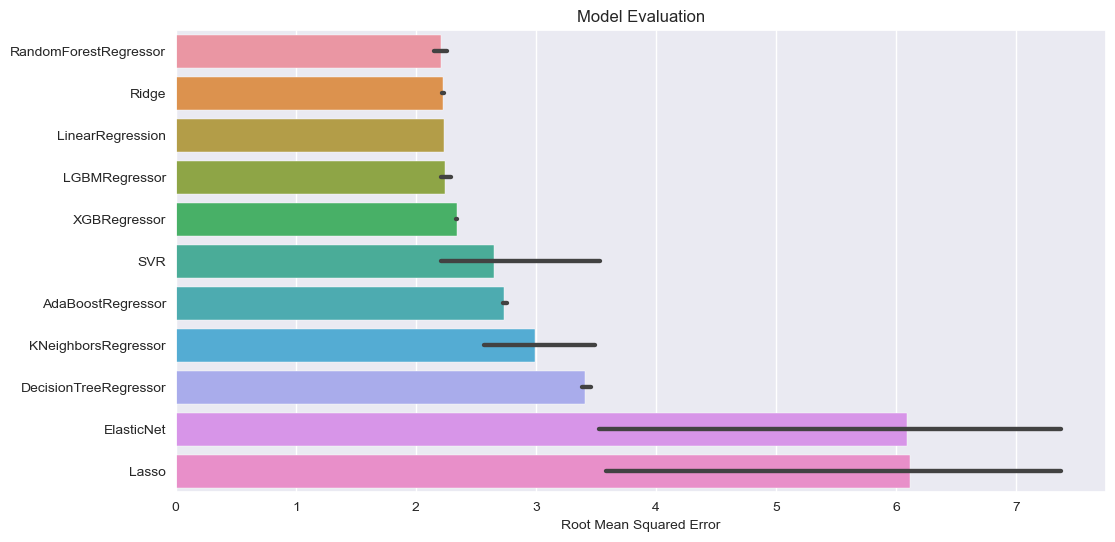

<IPython.core.display.Javascript object>

In [241]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.title("Model Evaluation", size=12)
sns.barplot(
    data=eval_data,
    y="model",
    x="rmse",
    order=eval_data.groupby("model")
    .agg({"rmse": "mean"})
    .reset_index()
    .sort_values("rmse")
    .model,
)
plt.ylabel("")
plt.xlabel("Root Mean Squared Error", size=10)
plt.show()

### Pycaret 을 활용한 자동 모델링

In [263]:
from pycaret.regression import *

<IPython.core.display.Javascript object>

In [264]:
reg = setup(data=auto, target="mpg", train_size=0.3)

,Description,Value
0,Session id,1184
1,Target,mpg
2,Target type,Regression
3,Data shape,"(398, 9)"
4,Train data shape,"(119, 9)"
5,Test data shape,"(279, 9)"
6,Numeric features,7
7,Categorical features,1
8,Rows with missing values,1.5%
9,Preprocess,True


<IPython.core.display.Javascript object>

In [265]:
best2 = compare_models(fold=10, sort="RMSE", n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2.1269,7.5238,2.6528,0.8093,0.1127,0.0958,0.4460
et,Extra Trees Regressor,2.2043,7.9740,2.7273,0.8059,0.1137,0.0987,0.0700
lightgbm,Light Gradient Boosting Machine,2.1953,8.1760,2.7518,0.7854,0.1166,0.0991,0.0230
ada,AdaBoost Regressor,2.3048,8.8341,2.8228,0.7834,0.1195,0.1046,0.0360
rf,Random Forest Regressor,2.2637,8.9131,2.8265,0.7859,0.1187,0.1012,0.0730
ridge,Ridge Regression,2.3195,9.0378,2.9493,0.7898,0.1332,0.1106,0.0190
gbr,Gradient Boosting Regressor,2.3338,9.6317,2.9496,0.7554,0.1243,0.1044,0.0260
lr,Linear Regression,2.3189,9.0496,2.9516,0.7896,0.1332,0.1105,0.0900
xgboost,Extreme Gradient Boosting,2.3918,9.3951,2.9521,0.7657,0.1253,0.1068,0.0310
br,Bayesian Ridge,2.4060,9.2998,2.9737,0.7823,0.1356,0.1143,0.0190


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [266]:
tuned_best2 = [tune_model(i, optimize="RMSE") for i in best2]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6380,4.3412,2.0836,0.8694,0.1026,0.0836
1,2.0397,7.0989,2.6644,0.9210,0.0916,0.0776
2,1.7496,4.2523,2.0621,0.8936,0.1057,0.0904
3,1.5660,4.1121,2.0278,0.8802,0.0918,0.0728
4,2.2617,7.9884,2.8264,0.8629,0.1032,0.0902
5,3.2399,17.5582,4.1903,0.6908,0.1778,0.1492
6,2.5268,8.6374,2.9389,0.7234,0.1274,0.1118
7,1.9363,8.3113,2.8829,0.8441,0.0988,0.0747
8,2.5192,8.6332,2.9382,0.6284,0.1208,0.1094


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8426,5.7871,2.4056,0.8259,0.1117,0.0922
1,2.5371,10.3237,3.2130,0.8851,0.1298,0.1081
2,1.4140,2.6826,1.6378,0.9329,0.0863,0.0752
3,0.7570,1.0372,1.0185,0.9698,0.0441,0.0343
4,2.4268,9.0827,3.0137,0.8441,0.1216,0.1078
5,4.1363,25.5773,5.0574,0.5496,0.2155,0.1816
6,1.9177,5.1107,2.2607,0.8363,0.1065,0.0872
7,2.1591,10.0388,3.1684,0.8117,0.1007,0.0794
8,2.1962,6.7388,2.5959,0.7100,0.1091,0.0960


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5749,4.8972,2.2130,0.8527,0.1087,0.0836
1,2.6709,9.5905,3.0969,0.8933,0.1229,0.1173
2,1.2750,2.5505,1.5970,0.9362,0.0808,0.0662
3,1.3032,3.1163,1.7653,0.9092,0.0831,0.0624
4,2.3241,9.5175,3.0850,0.8367,0.1175,0.0983
5,3.6565,20.4502,4.5222,0.6399,0.1975,0.1711
6,1.8183,4.1728,2.0428,0.8664,0.0839,0.0794
7,2.0519,9.7323,3.1197,0.8174,0.1105,0.0797
8,2.5768,9.0382,3.0064,0.6110,0.1220,0.1110


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1016,6.2231,2.4946,0.8128,0.1214,0.1061
1,2.6134,8.5710,2.9276,0.9046,0.1153,0.1134
2,1.3516,2.9531,1.7185,0.9261,0.0863,0.0707
3,1.1842,1.9383,1.3922,0.9435,0.0570,0.0500
4,2.6857,9.9606,3.1560,0.8291,0.1206,0.1134
5,3.4564,19.8939,4.4603,0.6497,0.2014,0.1636
6,2.5045,8.7406,2.9564,0.7201,0.1252,0.1093
7,2.0917,10.0470,3.1697,0.8115,0.1046,0.0779
8,2.9980,12.7995,3.5776,0.4491,0.1462,0.1315


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1932,6.9336,2.6332,0.7914,0.1316,0.1172
1,2.2684,7.5860,2.7543,0.9156,0.1094,0.0976
2,1.1297,2.6291,1.6214,0.9342,0.0851,0.0615
3,0.5811,0.4338,0.6586,0.9874,0.0281,0.0256
4,2.4776,8.5930,2.9314,0.8525,0.1191,0.1103
5,4.4996,29.2426,5.4076,0.4850,0.2366,0.2018
6,2.4697,8.0287,2.8335,0.7429,0.1187,0.1057
7,2.2026,11.1890,3.3450,0.7901,0.1041,0.0799
8,2.5994,9.1691,3.0281,0.6054,0.1211,0.1125


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


<IPython.core.display.Javascript object>

In [267]:
blend_best2 = blend_models(estimator_list=tuned_best2, fold=5, optimize="RMSE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1205,7.1937,2.6821,0.8840,0.1176,0.1010
1,1.1479,2.1033,1.4503,0.9476,0.0726,0.0577
2,3.0957,16.1865,4.0232,0.7193,0.1691,0.1372
3,2.1050,7.5989,2.7566,0.8206,0.1040,0.0854
4,2.3045,7.1353,2.6712,0.7676,0.1147,0.1061
Mean,2.1547,8.0435,2.7167,0.8278,0.1156,0.0975
Std,0.6205,4.5462,0.8143,0.0812,0.0312,0.0260


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [268]:
final_model = finalize_model(blend_best2)
final_model

Pipeline(memory=Memory(location=C:\Users\sanga\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['cylinders', 'displacement',
                                             'horsepower', 'weight',
                                             'acceleration', 'model year',
                                             'origin'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['car name'],
                                    transformer=SimpleImputer(strategy='most_f...
                                                            random_state=1184,
                                                            reg_alpha=0.7,
                                                            reg_lambda=0.15)),
                                             ('AdaBoost Regressor',
                                              AdaBoostRegressor(learning_rate=0.3,
                                                                loss='square',
                                                                n_estimators=280,
                                                                random_state=1184)),
                                             ('Random Forest Regressor',
                                              RandomForestRegressor(criterion='mse',
                                                                    max_depth=4,
                                                                    min_impurity_decrease=0.005,
                                                                    min_samples_leaf=6,
                                                                    min_samples_split=10,
                                                                    n_estimators=250,
                                                                    n_jobs=-1,
                                                                    random_state=1184))],
                                 n_jobs=-1))])

<IPython.core.display.Javascript object>

In [269]:
pred = predict_model(blend_best2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.3257,12.0762,3.4751,0.8191,0.1254,0.0953


<IPython.core.display.Javascript object>